# Project Data Science Blog Post
## Economic and Business Data: United States of America Business Formation Statistics
### Author: Felix Reichel

In this notebook I will analyse the business formation statistics from the [United States Census Bureau](https://www.census.gov/econ/bfs/current/index.html).
The dataset contains the number of business applications (adjusted for seasonal variation) in the United States and geographical subregions, sorted by sectors and types of applications. The dataset contains numbers from mid-2004 until February 2025.

We will address the following business questions:
- How can we best model the number of business applications per month over time? Is it feasible to predict future application numbers from previous data?
- How did the trend in applications change after the COVID-19 pandemic compared to data before 2020?
- Can the data from the pre-Covid times be used to predict trends after 2020?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


## Data Understanding

In [2]:
df = pd.read_csv("bfs_monthly.csv")

Let's get a look at the data:

In [3]:
df.head()

,sa,naics_sector,series,geo,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,U,TOTAL,BA_BA,US,2025,497030,440230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U,NAICS11,BA_BA,US,2025,5141,4258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U,NAICS21,BA_BA,US,2025,547,472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U,NAICS22,BA_BA,US,2025,689,663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,U,NAICS23,BA_BA,US,2025,49525,44621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34732 entries, 0 to 34731
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sa            34732 non-null  object
 1   naics_sector  34732 non-null  object
 2   series        34732 non-null  object
 3   geo           34732 non-null  object
 4   year          34732 non-null  int64 
 5   jan           33060 non-null  object
 6   feb           33060 non-null  object
 7   mar           31844 non-null  object
 8   apr           31844 non-null  object
 9   may           31844 non-null  object
 10  jun           31844 non-null  object
 11  jul           33516 non-null  object
 12  aug           33516 non-null  object
 13  sep           33516 non-null  object
 14  oct           33516 non-null  object
 15  nov           33516 non-null  object
 16  dec           33516 non-null  object
dtypes: int64(1), object(16)
memory usage: 4.5+ MB


In [5]:
df.describe()

,year
count,34732.000000
mean,2013.984683
std,6.145463
min,2004.000000
25%,2009.000000
50%,2014.000000
75%,2019.000000
max,2025.000000


Concentrate on data for total business applications for all of US

In [6]:
mask = ((df['sa'] == 'U')
        & (df['naics_sector'] == 'TOTAL')
        & (df['series'] == 'BA_BA')
        & (df['geo'] == 'US'))
df_us_total = df[mask].copy()
df_us_total.drop(columns=['sa', 'naics_sector', 'series', 'geo'], inplace=True)

In [7]:
df_us_total

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,2025,497030,440230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1216,2024,577568,458672,470784,443598,504575,401446,456420,388560,369528,458177,350656,321663
2432,2023,441031,464904,617545,457151,533041,435147,412423,523073,408249,404868,447547,316492
3648,2022,449058,449408,562756,445650,410045,472624,364903,469377,365683,368558,406473,295145
4864,2021,501488,460691,612420,511873,483476,516980,380849,382728,461557,365884,336174,375586
6308,2020,362175,323296,282548,301789,285507,349530,585048,432629,465818,349552,307973,310328
7980,2019,354756,319377,327882,299706,343408,270171,240092,325560,249652,315321,228572,224336
9652,2018,304316,305131,394145,291893,348422,276202,249185,329760,248809,242297,283342,213669
11324,2017,270066,277874,356418,267025,309372,249383,229436,300244,223018,231304,275026,192730
12996,2016,265430,257163,321951,249523,240226,252132,224371,276166,218218,208977,247635,186797


The data contains the number of applications per month in columns, sorted per month. With the `year` column in addition, the data can be filtered for a certain date. The other columns help to filter the data for region, sector and type of business applications. The dataset contains empty values for months in the future (after Feb-2025) and before July 2004.

## Data preparation

In this form, the data is not well suited to perform a time-series analysis. To get better access to the temporal evolution of the datapoints, I will unpivot the month-columns and create a date column, and sort the data by date. Furthermore, I will only concentrate on the total number of business application in the United States and sort check for subregions.

In [8]:
def get_time_series_dataframe(df, sa='U', naics_sector='TOTAL', series='BA_BA', geo='US'):
    """
    Function to get time series dataframe from tabulated dataset per month, filtered by sa, naics_sector, series and geo.

    :param df: Dataframe to unpivot
    :param sa: Use seasonally adjusted data or unadjusted data? default is 'U' (unadjusted)
    :param naics_sector: 2-digit NAICS Sector. Default is 'TOTAL' (All NAICS)
    :param series: Type of business application. Default is 'BA_BA' (All business Applications)
    :param geo: Geopraphic Region. Default is 'US' (United States)
    :return: Unpivoted dataframe sorted by date
    """
    # filter for different features
    mask = ((df['sa'] == sa)
            & (df['naics_sector'] == naics_sector)
            & (df['series'] == series)
            & (df['geo'] == geo))
    df = df[mask].copy()
    # delete unnecessary columns
    df.drop(columns=['sa', 'naics_sector', 'series', 'geo'], inplace=True)

    # unpivot dataframe
    df = pd.melt(df,
                 id_vars=['year'],
                 var_name='month',
                 value_vars=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                 value_name='business_applications'
                 )
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'],
                                     format='%Y-%b')
    df.sort_values(by='date', ascending=True, inplace=True)
    # rows containing nans have no more useful info
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['business_applications'] = df['business_applications'].astype(int)

    return df

In [9]:
df_us_total = get_time_series_dataframe(df)


Get a look at the dataframe:

In [10]:
df_us_total

,year,month,business_applications,date
0,2004,jul,166448,2004-07-01
1,2004,aug,171070,2004-08-01
2,2004,sep,162742,2004-09-01
3,2004,oct,207389,2004-10-01
4,2004,nov,176104,2004-11-01
...,...,...,...,...
243,2024,oct,458177,2024-10-01
244,2024,nov,350656,2024-11-01
245,2024,dec,321663,2024-12-01
246,2025,jan,497030,2025-01-01


In [11]:
df_us_total.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   year                   248 non-null    int64         
 1   month                  248 non-null    object        
 2   business_applications  248 non-null    int64         
 3   date                   248 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.9+ KB


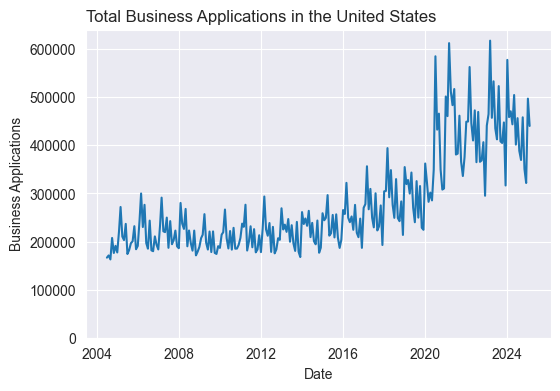

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(df_us_total['date'], df_us_total['business_applications'])

plt.ylim(0)
plt.xlabel("Date")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.show()

The data seems to be cyclical within the years. Let's check the data per year to see any patterns within one year:

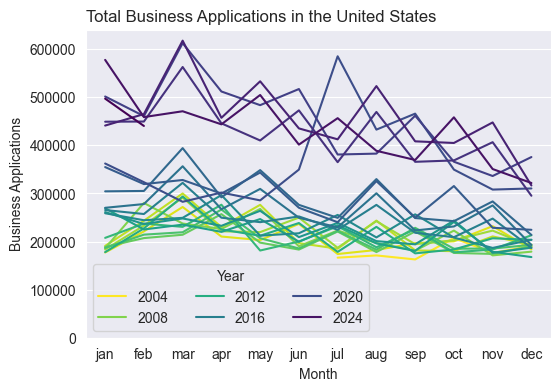

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.pointplot(df_us_total, x='month', y='business_applications', hue='year',
              order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
              palette='viridis_r',
              markersize=0, lw=1.5,
              legend='auto',
              )
plt.ylim(0)
plt.xlabel("Month")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.legend(title="Year", ncol=3, loc='lower left')
plt.show()



March, May, August, and October/November seem to be particularly busy. Let's see if the seasonally adjusted data takes out the cyclical nature of the data:

In [14]:
df_us_total_adj = get_time_series_dataframe(df, sa='A')

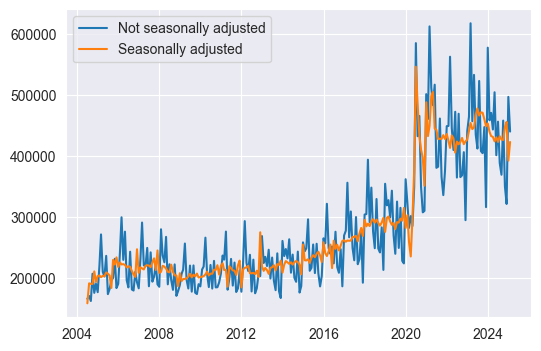

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(df_us_total['date'], df_us_total['business_applications'], label='Not seasonally adjusted')
ax.plot(df_us_total_adj['date'], df_us_total_adj['business_applications'], label='Seasonally adjusted')
plt.ylim(0)
plt.xlabel("Year")
plt.xticks(df_plot['year'].astype(int)[::2])
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.legend()
plt.show()

The seasonally-adjusted data indeed helps to smoothen the curve.

Group data per year:

In [16]:
df_us_total_yearly = df_us_total.groupby(['year'], as_index=False).sum(numeric_only=True)
df_us_total_adj_yearly = df_us_total_adj.groupby(['year'], as_index=False).sum(numeric_only=True)

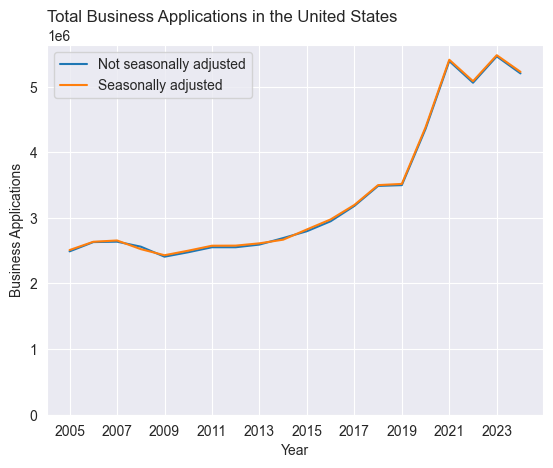

In [17]:
df_plot = df_us_total_yearly[(2005 <= df_us_total_yearly['year']) & (df_us_total_yearly['year'] <= 2024)].copy()
plt.plot(df_plot['year'], df_plot['business_applications'], label='Not seasonally adjusted')
df_plot = df_us_total_adj_yearly[(2005 <= df_us_total_adj_yearly['year']) & (df_us_total_adj_yearly['year'] <= 2024)].copy()
plt.plot(df_plot['year'], df_plot['business_applications'], label='Seasonally adjusted')

plt.ylim(0)
plt.xlabel("Year")
plt.xticks(df_plot['year'].astype(int)[::2])
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.legend()
plt.show()

When considering the total sum of applications per year, the differences between the unadjusted and seasonally adjusted data vanish.

Let's check how the average number has changed after the COVID-19 pandemic. For this, I will consider data before 2020 pre-COVID and after 2021 post-COVID.
Because 2020 was a special year that is also reflected by a jump of applications in the data, I will not consider this year for the analysis.

In [18]:
df_us_total_adj['Pandemic Era'] =  np.nan
df_us_total_adj['Pandemic Era'] = df_us_total_adj['Pandemic Era'].astype(str)
df_us_total_adj.loc[df_us_total_adj['year'] < 2020, 'Pandemic Era'] = 'Pre-COVID'
df_us_total_adj.loc[df_us_total_adj['year'] > 2020, 'Pandemic Era'] = 'Post-COVID'

df_mean_pan_era = df_us_total_adj.groupby(['Pandemic Era'], as_index=False).mean(numeric_only=True)

In [19]:
df_mean_pan_era

,Pandemic Era,year,business_applications
0,Post-COVID,2022.600000,440262.660000
1,Pre-COVID,2011.741935,230312.731183
2,nan,2020.000000,365036.916667


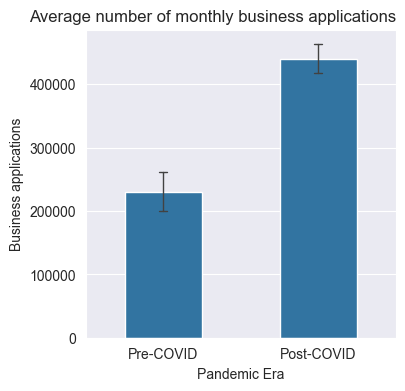

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.barplot(data=df_us_total_adj, x='Pandemic Era', y='business_applications',
            order=['Pre-COVID', 'Post-COVID'],
            width=0.5,
            estimator=np.mean, errorbar='sd', capsize=0.05,
            err_kws=dict(linewidth=1),
            )
plt.ylabel("Business applications")
plt.title("Average number of monthly business applications", loc='right')
plt.show()

## Modeling
### Linear regression for Seasonally adjusted data

Since we have time-series data in a purely numerical format, regression seems to be an appropriate method to model the data.

In [21]:
# use index of dataframe for x-axis, as it gives range of months in the dataset to use for the regression
# reshape for correct format in sklearn Linear Regressor
X = df_us_total_adj.index.values.reshape(-1, 1)
y = df_us_total_adj[['business_applications']]

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

# The coefficients
print("Coefficients: \n", lr.coef_[0,0])
# The root mean squared error
print("Root mean squared error: %.2f" % root_mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

Coefficients: 
 1095.6092692567324
Root mean squared error: 49378.89
Coefficient of determination: 0.72


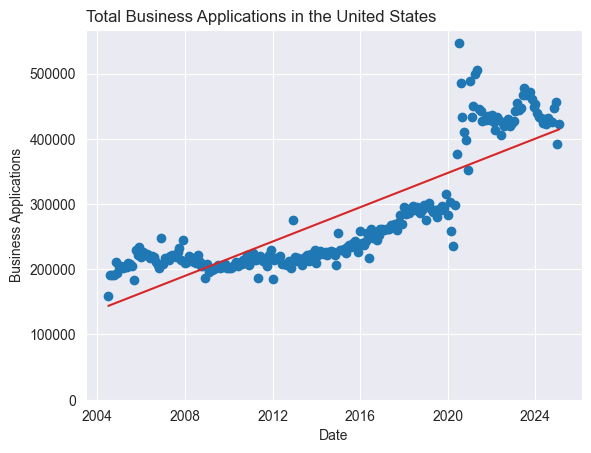

In [22]:
plt.scatter(df_us_total_adj['date'], y)
plt.plot(df_us_total_adj['date'], y_pred, color='tab:red')

plt.ylim(0)
plt.xlabel("Date")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.show()

The scores for the linear regression model are not great. This is easily explained, as the data is clearly not linear and has a huge jump and volatility in the number of around the year 2020 (COVID19 pandemic). Because of this irregularity in the data, a decision tree might be better suited to model the data.

Tree depth: 2
Root mean squared error: 2e+04
Coefficient of determination: 0.95

Tree depth: 3
Root mean squared error: 1.7e+04
Coefficient of determination: 0.97

Tree depth: 4
Root mean squared error: 1.4e+04
Coefficient of determination: 0.98

Tree depth: 5
Root mean squared error: 1.2e+04
Coefficient of determination: 0.98



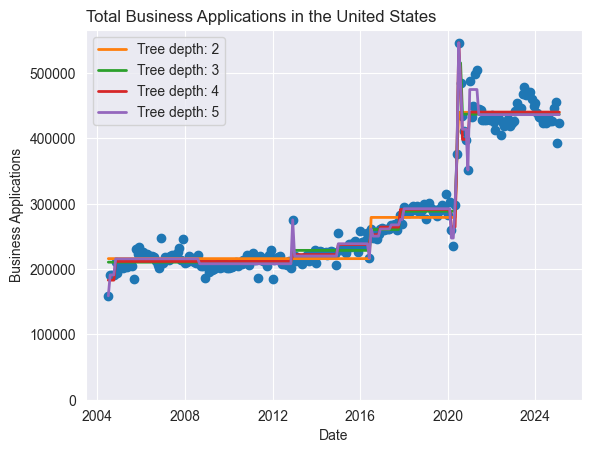

In [23]:
clf_1 = DecisionTreeRegressor(max_depth=2, random_state=42)
clf_2 = DecisionTreeRegressor(max_depth=3, random_state=42)
clf_3 = DecisionTreeRegressor(max_depth=4, random_state=42)
clf_4 = DecisionTreeRegressor(max_depth=5, random_state=42)

plt.scatter(df_us_total_adj['date'], y)
clfs = [clf_1, clf_2, clf_3, clf_4]
for ii, clf in enumerate(clfs):
    clf.fit(X, y)
    y_tree = clf.predict(X)
    depth = clf.get_depth()
    print(f"Tree depth: {depth}")
    print("Root mean squared error: {:.2}".format(root_mean_squared_error(y, y_tree)))
    print("Coefficient of determination: {:.2}\n".format(r2_score(y, y_tree)))

    plt.plot(df_us_total_adj['date'], y_tree,
             color=f"C{ii+1}",
             lw=2,
             label=f"Tree depth: {depth}")

plt.ylim(0)
plt.xlabel("Date")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.legend()
plt.show()

A tree depth of 3 seems to be appropriate to model the data. Increasing the depth only slightly increases $R^2$ but already shows signs of overfitting.

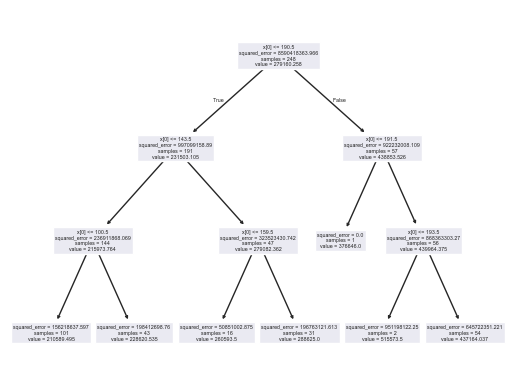

In [24]:
# plot the decision tree
tree.plot_tree(clf_2)
plt.show()

#### Check for differences in pre-COVID and post-COVID predictions.
Since year 2020 was an anomaly, we leave it out of the analysis completely.

In [25]:
df_pre_covid = df_us_total_adj[(df_us_total['year'] < 2020)].copy()
df_post_covid = df_us_total_adj[(df_us_total['year'] > 2020)].copy()

##### Pre-COVID

In [26]:
# use index of dataframe for axis, as it gives range of months in the dataset to use for the regression
X_pre = df_pre_covid.index.values.reshape(-1, 1)
y_pre = df_pre_covid[['business_applications']]

lr_pre = LinearRegression()
lr_pre.fit(X_pre, y_pre)
y_pre_pred = lr_pre.predict(X_pre)

# The coefficients
print("Coefficients: \n", lr_pre.coef_[0,0])
# The root mean squared error
print("Root mean squared error: %.2f" % root_mean_squared_error(y_pre, y_pre_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_pre, y_pre_pred))

Coefficients: 
 455.26187170437635
Root mean squared error: 18845.39
Coefficient of determination: 0.63


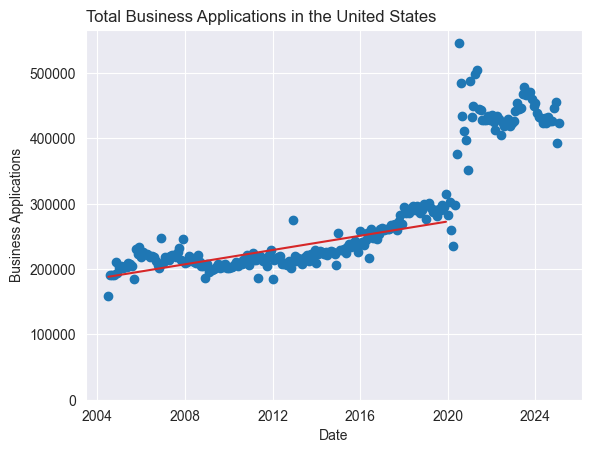

In [27]:
plt.scatter(df_us_total_adj['date'], y)
plt.plot(df_pre_covid['date'], y_pre_pred, color='tab:red')

plt.ylim(0)
plt.xlabel("Date")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.show()

##### Post-COVID

In [28]:
# use index of dataframe for axis, as it gives range of months in the dataset to use for the regression
X_post = df_post_covid.index.values.reshape(-1, 1)
y_post = df_post_covid[['business_applications']]

lr_post = LinearRegression()
lr_post.fit(X_post, y_post)
y_post_pred = lr_post.predict(X_post)

# The coefficients
print("Coefficients: \n", lr_post.coef_[0,0])
# The root mean squared error
print("Root mean squared error: %.2f" % root_mean_squared_error(y_post, y_post_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_post, y_post_pred))

Coefficients: 
 -280.0634333733493
Root mean squared error: 21886.30
Coefficient of determination: 0.03


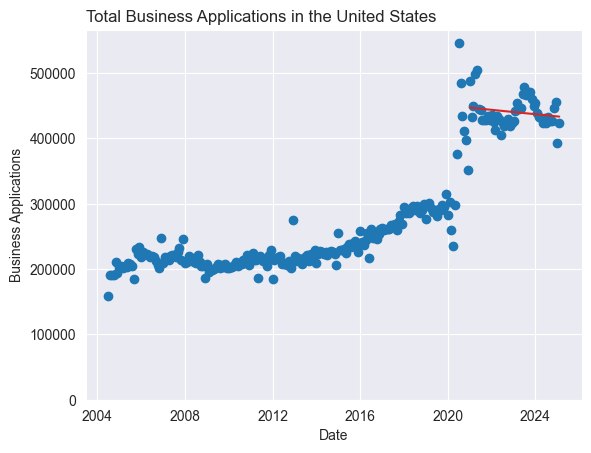

In [29]:
plt.scatter(df_us_total_adj['date'], y)
plt.plot(df_post_covid['date'], y_post_pred, color='tab:red')

plt.ylim(0)
plt.xlabel("Date")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.show()

##### Plot combining predictions from different models

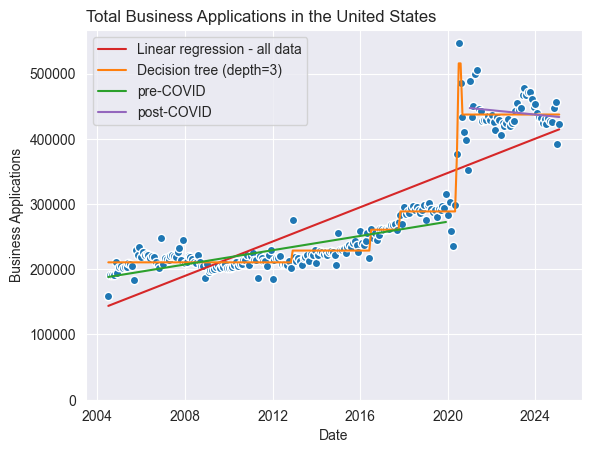

In [30]:
x_plot = df_us_total_adj['date']

plt.scatter(x_plot, df_us_total_adj['business_applications'], edgecolors='w', linewidths=1)
plt.plot(x_plot, y_pred, color='tab:red', label="Linear regression - all data")
plt.plot(x_plot, clf_2.predict(X), color='tab:orange', label="Decision tree (depth=3)")
plt.plot(df_pre_covid['date'], y_pre_pred, color='tab:green', label="pre-COVID")
plt.plot(df_post_covid['date'], y_post_pred, color='tab:purple', label="post-COVID")

plt.ylim(0)
plt.xlabel("Date")
plt.ylabel("Business Applications")
plt.title("Total Business Applications in the United States", loc='left')
plt.legend()
plt.show()

##### Predict future applications

What do the different models predict for applications in January 2026?


In [31]:
date_future = pd.to_datetime('2026-01')
# compute difference in month from first date entry in dataframe
month_delta = (date_future - df_us_total_adj['date'].min()).days // 30

x_future = np.array([month_delta]).reshape(-1, 1)
y_future_lr = lr.predict(x_future)
y_future_tree = clf_2.predict(x_future)
y_future_pre = lr_pre.predict(x_future)
y_future_post = lr_post.predict(x_future)

In [32]:
print("Predicted business applications in January 2026:")
print(f"Linear regression - all data: {int(y_future_lr[0,0])}")
print(f"Decision tree (depth=3): {int(y_future_tree[0])}")
print(f"Linear regression - pre-COVID: {int(y_future_pre[0,0])}")
print(f"Linear regression - post-COVID: {int(y_future_post[0,0])}")

Predicted business applications in January 2026:
Linear regression - all data: 429806
Decision tree (depth=3): 437164
Linear regression - pre-COVID: 307024
Linear regression - post-COVID: 429480


## Evaluation

A linear regression was performed on all datapoints resulting in a root mean squared error (RMSE) of roughly 50k applications and $R^2=0.72$.
The RMSE tells us the average distance of the predicted values from the true data.
This makes it a measure of accuracy for regression models.
The aim is to minimize the RMSE.
The $R^2$ indicates the proportion of variance in the dependent variable that's explained by the independent variables in a regression model, ranging from 0 to 1.
$R^2$ of 1 means the model perfectly explains all the variance in the dependent variable.
$R^2$ of 0 means the model doesn't explain any of the variance.
A higher $R^2$ value generally indicates a better fit, meaning the model explains more of the variance.

Since this is not a great model, additionally a decision tree regressor was trained with tree depths 2-5.
A tree depth of 3 was chosen as a good compromise of accuracy and avoiding overfitting.
This model resulted in an RMSE of 17k applications and $R^2=0.97$, outperforming the accuracy and variance of the linear regression model. Because of the volatility in the data around the year 2020, both models are unlikely to help for future predictions.

Modeling the data before and after the year 2020 (pre- and post-COVID) resulted in a change of the sign of the coefficient. This means that before 2020 the number of business applications was increasing and that the trend is decreasing since 2021. But the total number of applications increased rapidly after 2020.

The pre-COVID data is not suited to predict the data after 2020 because trend completely flipped, the number of applications tends to decrease since 2021. Predicting how the number of applications will evolve in the future is very difficult to tell from this data alone and requires additional features.

##### Prediction of future application numbers

The linear regression models for all data, the post-COVID data and the Decision Tree Regressor all predict close number for January 2026: around 430k applications. The linear regression model for the pre-COVID data predicts 307k applications.